## TODO: run umap instead of tsne
add perplexity as parameter and output

In [1]:
#indir = "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/dominant_clone_clust/"
#outdir= "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clone_clust_embed/tsne_perp30_donperp10/"
#perplexity = 30
donor_perplexity=10

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/gff_A2_black/annotation_clones/dominant_clone_clust"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/gff_A2_black/annotation_clones/clone_clust_embed/tsne_perp50_donperp10"
sample_names = "Control,Flt3l,Input"
perplexity = 50 


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join, basename, exists
import click
from glob import glob
from mplh.fig_utils import helper_save as hs
from mplh.cluster_help import plot_cluster as pc
import logging
import os
from matplotlib import rcParams
#import scanpy
#rcParams['lines.markersize'] = 10
import numpy as np
from sklearn.manifold import TSNE

fig_utils from mplh


In [3]:
np.random.seed(42)

In [4]:
if not exists(outdir):
    os.mkdir(outdir)

## T-sne and plotting features for t-sne

In [5]:
def run_tsne(df, meta, perplexity):
    X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                  init='random').fit_transform(df.values)

    tsne_df = pd.DataFrame(X_embedded, index=df.index).rename({0:"t-SNE1",1:"t-SNE2"}, axis=1)

    tsne_meta_df = pd.merge(tsne_df, meta, left_index=True, right_index=True)
    tsne_meta_features_df = pd.merge(tsne_meta_df, df, left_index=True, right_index=True)
    return tsne_meta_features_df


def plot_tsne(tsne_meta_features_df, curr_outdir, features, isCond=True, useAllDonor=True):
    g = sns.FacetGrid(tsne_meta_features_df, col="donor",col_wrap=4)
    if isCond:
        g.map_dataframe(sns.scatterplot, x="t-SNE1", y="t-SNE2", hue="condition", s=20)
    else:
        g.map_dataframe(sns.scatterplot, x="t-SNE1", y="t-SNE2", s=20)
    plt.legend()
    plt.savefig(join(curr_outdir, "umap.pdf"))
    
    for c in features:
        plt.figure()
        sns.scatterplot(data=tsne_meta_features_df, x="t-SNE1", y="t-SNE2", hue=c, s=20)
        plt.suptitle(f"Cluster {c}")
        plt.tight_layout()
        plt.legend()
        plt.savefig(join(curr_outdir, f"clust_{c}.png"))
        
        if isCond:
            g = sns.FacetGrid(tsne_meta_features_df, col="donor", row="condition")
        else:
            g = sns.FacetGrid(tsne_meta_features_df, col="donor", col_wrap=2)    
        g.map_dataframe(sns.scatterplot, x="t-SNE1", y="t-SNE2", hue=c, s=20)
        plt.suptitle(f"Cluster {c}")
        plt.tight_layout()
        plt.legend()
        plt.savefig(join(curr_outdir, f"clust_{c}_split.png"))
        plt.close()
        
    if useAllDonor:
        f=plt.figure()
        if isCond:
            sns.scatterplot(data=tsne_meta_features_df, x="t-SNE1", y="t-SNE2", hue="condition", s=20)
        else:
            sns.scatterplot(data=tsne_meta_features_df, x="t-SNE1", y="t-SNE2", s=20)
        plt.legend()
        plt.savefig(join(curr_outdir, "allDonors_umap.pdf"))

        for c in features:
            if isCond:
                g = sns.FacetGrid(tsne_meta_features_df, col="condition")
                g.map_dataframe(sns.scatterplot, x="t-SNE1", y="t-SNE2", hue=c, s=20)
            else:
                f=plt.figure()
                sns.scatterplot(data=tsne_meta_features_df, x="t-SNE1", y="t-SNE2", hue=c, s=20)
            plt.suptitle(f"Cluster {c}")
            plt.tight_layout()
            plt.legend()
            plt.savefig(join(curr_outdir, f"allDonors_clust_{c}.png"))
            plt.close()
    return

## Run normalized counts

### a)  combined donors

In [11]:
clust_clones_counts_norm = pd.read_csv(join(indir, "cluster_clone_counts_normalized.csv"), index_col=0)
meta = pd.read_csv(join(indir, "cluster_clone_meta.csv"), index_col=0)
## Replace '/' with '.' in cluster names
clust_clones_counts_norm.columns = clust_clones_counts_norm.columns.str.replace("/",".") 
clust_clones_counts_norm

,CLP,DC,MEP,MPP.CMP.GMP,MPP.CMP.GMP B,MPP.CMP.GMP C,MPP.CMP.GMP D,eosonophil,erythroid,macrophage,meg.erythroid,monocyte,neutrophil,neutrophil B
ID,,,,,,,,,,,,,,
0_0_Control,0.000000,0.000000,0.000000,0.230381,0.000000,0.339325,0.141257,0.449574,0.391459,0.464285,0.403156,0.329796,0.464285,0.339325
0_0_Flt3l,0.000000,0.000000,0.000000,0.133497,0.000000,0.409173,0.279796,0.448250,0.375605,0.526244,0.404909,0.386178,0.509101,0.413293
0_0_Input,0.327566,0.368266,0.403064,0.508600,0.544297,0.251529,0.000000,0.251529,0.083843,0.216731,0.132888,0.000000,0.083843,0.132888
0_10_Control,0.000000,0.000000,0.000000,0.000000,0.000000,0.206938,0.089124,0.250201,0.230381,0.319505,0.141257,0.178247,0.296062,0.206938
0_10_Flt3l,0.084227,0.000000,0.000000,0.000000,0.000000,0.195569,0.133497,0.252681,0.168454,0.217724,0.168454,0.168454,0.301951,0.252681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_8_Flt3l,0.000000,0.000000,0.000000,0.000000,0.000000,0.170496,0.239322,0.197940,0.340992,0.305611,0.283188,0.085248,0.305611,0.255744
1_8_Input,0.000000,0.173961,0.224841,0.393461,0.369486,0.260941,0.000000,0.000000,0.000000,0.000000,0.201962,0.000000,0.000000,0.000000
1_9_Control,0.000000,0.000000,0.000000,0.000000,0.000000,0.173840,0.086920,0.288742,0.330936,0.300694,0.275530,0.086920,0.311605,0.288742


FileNotFoundError: [Errno 2] No such file or directory: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/gff_A2_black/annotation_clones/clone_clust_embed/tsne_perp50_donperp10/combinedDonors/clust_MPP/CMP/GMP.png'

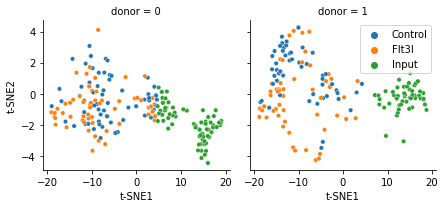

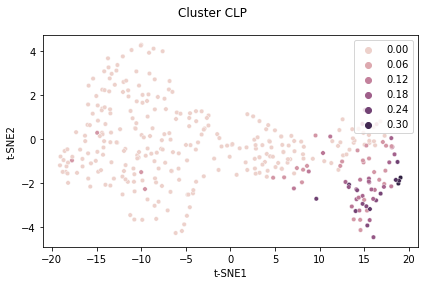

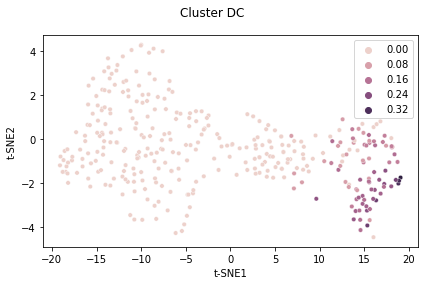

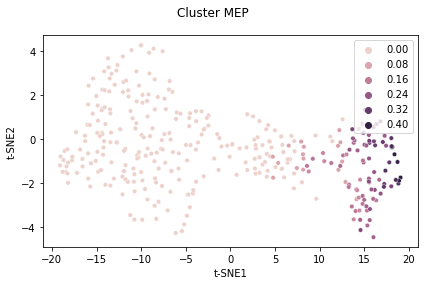

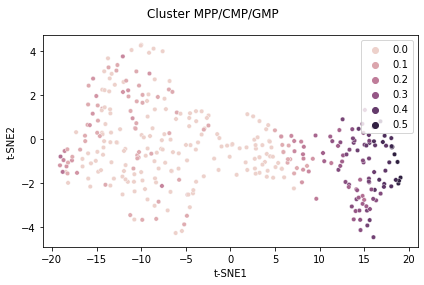

In [6]:
%matplotlib inline

clust_clones_counts_norm

combinedDonors_outdir = join(outdir, "combinedDonors")

if not exists(combinedDonors_outdir):
    os.mkdir(combinedDonors_outdir)

tsne_meta_features_df = run_tsne(clust_clones_counts_norm, meta, perplexity=perplexity)
tsne_meta_features_df.to_csv(join(combinedDonors_outdir,"umap.csv"))
plot_tsne(tsne_meta_features_df, combinedDonors_outdir, features=clust_clones_counts_norm.columns,
          useAllDonor=True, isCond=True)

### b)  separate for each donor

In [ ]:
%matplotlib inline

sepDonors_outdir = join(outdir, "sepDonors")
if not exists(sepDonors_outdir):
    os.mkdir(sepDonors_outdir)
for ind, val in meta.groupby("donor"):
    don_dir= join(sepDonors_outdir, f"donor_{ind}")
    if not exists(don_dir):
        os.mkdir(don_dir)

    curr = clust_clones_counts_norm.loc[val.index]    
    tsne_meta_features_df = run_tsne(curr, val, perplexity=donor_perplexity)
    tsne_meta_features_df.to_csv(join(don_dir,"umap.csv"))
    plot_tsne(tsne_meta_features_df, don_dir,features=clust_clones_counts_norm.columns,
              useAllDonor=False, isCond=True) 

## Combine the clones over the conditions

In [13]:
combinedConditions_clust_clones_counts_norm = pd.read_csv(join(indir, "combinedConditions_cluster_clone_counts_normalized.csv"), 
                                                         index_col=0)
combinedConditions_meta = pd.read_csv(join(indir, "combinedConditions_cluster_clone_meta.csv"), index_col=0)
## Replace '/' with '.' in cluster names
combinedConditions_clust_clones_counts_norm.columns = combinedConditions_clust_clones_counts_norm.columns.str.replace("/",".") 

combinedConditions_clust_clones_counts_norm

,CLP,DC,MEP,MPP.CMP.GMP,MPP.CMP.GMP B,MPP.CMP.GMP C,MPP.CMP.GMP D,eosonophil,erythroid,macrophage,meg.erythroid,monocyte,neutrophil,neutrophil B
ID,,,,,,,,,,,,,,
0_0,0.296049,0.332833,0.364283,0.470529,0.491928,0.425461,0.271655,0.477677,0.411182,0.520610,0.431958,0.391757,0.506678,0.416152
0_1,0.288507,0.296049,0.321892,0.452936,0.488222,0.388678,0.240205,0.411182,0.378881,0.476284,0.405975,0.360307,0.427670,0.327499
0_10,0.120102,0.212731,0.271655,0.382245,0.408609,0.262143,0.151552,0.296049,0.240205,0.315981,0.251723,0.240205,0.337919,0.280405
0_11,0.075776,0.212731,0.151552,0.321892,0.303105,0.280405,0.262143,0.303105,0.288507,0.371826,0.332833,0.240205,0.356181,0.315981
0_12,0.075776,0.195879,0.175947,0.388678,0.400508,0.271655,0.120102,0.321892,0.240205,0.271655,0.315981,0.175947,0.360307,0.280405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_53,0.000000,0.000000,0.000000,0.000000,0.000000,0.076524,0.000000,0.076524,0.000000,0.000000,0.000000,0.000000,0.121288,0.076524
1_6,0.121288,0.076524,0.330732,0.434078,0.363864,0.306097,0.121288,0.229572,0.355367,0.283173,0.355367,0.153048,0.359697,0.306097
1_7,0.076524,0.121288,0.325069,0.422686,0.409982,0.312790,0.153048,0.283173,0.395624,0.274336,0.291355,0.121288,0.336118,0.242576


### c) Combining across conditions and donors

In [ ]:
%matplotlib inline
combinedConditions_combinedDonors_outdir = join(outdir, "combinedConditions_combinedDonors")

if not exists(combinedConditions_combinedDonors_outdir):
    os.mkdir(combinedConditions_combinedDonors_outdir)

tsne_meta_features_df = run_tsne(combinedConditions_clust_clones_counts_norm, combinedConditions_meta,
                                perplexity=perplexity)

tsne_meta_features_df.to_csv(join(combinedConditions_combinedDonors_outdir,"umap.csv"))

plot_tsne(tsne_meta_features_df, combinedConditions_combinedDonors_outdir,
          features=combinedConditions_clust_clones_counts_norm.columns,
          isCond=False, useAllDonor=True)

### d) Combining across conditions and separating by donors

In [ ]:
%matplotlib inline

combinedConditions_sepDonors_outdir = join(outdir, "combinedConditions_sepDonors")
if not exists(combinedConditions_sepDonors_outdir):
    os.mkdir(combinedConditions_sepDonors_outdir)
for ind, val in combinedConditions_meta.groupby("donor"):
    don_dir= join(combinedConditions_sepDonors_outdir, f"donor_{ind}")
    if not exists(don_dir):
        os.mkdir(don_dir)

    curr = combinedConditions_clust_clones_counts_norm.loc[val.index]    
    tsne_meta_features_df = run_tsne(curr, val, perplexity=donor_perplexity)
    
    tsne_meta_features_df.to_csv(join(don_dir,"umap.csv"))

    plot_tsne(tsne_meta_features_df, don_dir, features=combinedConditions_clust_clones_counts_norm.columns,
              isCond=False, useAllDonor=False)